In [70]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [71]:
# Data Preparation

# Parameters
tickers = ['AAPL', 'COKE', 'VZ', 'F']
tickers.sort()

start = '2016-01-01'

# YF download
df = yf.download(tickers, start=start)

# Reformat Dataframe
df = df.stack().reset_index()

# Add daily return column
df['Ri'] = df.groupby("Ticker")['Adj Close'].pct_change()

df = df.dropna()

df

[*********************100%%**********************]  4 of 4 completed
/tmp/ipykernel_1300898/842334263.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Ri
4,2016-01-05,AAPL,23.288242,25.677500,26.462500,25.602501,26.437500,223164000,-0.025059
5,2016-01-05,COKE,166.498138,176.740005,179.410004,174.300003,177.020004,32600,0.009654
6,2016-01-05,F,8.630337,13.720000,14.000000,13.510000,13.970000,50267500,-0.017896
7,2016-01-05,VZ,29.956104,46.500000,46.549999,45.630001,46.200001,15632800,0.013734
8,2016-01-06,AAPL,22.832499,25.174999,25.592501,24.967501,25.139999,273829600,-0.019570
...,...,...,...,...,...,...,...,...,...
8671,2024-08-14,VZ,40.900002,40.900002,41.099998,40.490002,40.599998,10930500,0.002943
8672,2024-08-15,AAPL,224.610001,224.610001,224.869995,222.759995,224.550003,8665440,0.013034
8673,2024-08-15,COKE,1262.540039,1262.540039,1267.930054,1262.540039,1267.930054,3560,0.003473
8674,2024-08-15,F,10.461500,10.461500,10.485000,10.390000,10.370000,9240360,0.027652


In [72]:
benchmark = 'IWV'

# YF download
bmk = yf.download(benchmark, start=start)

# Reformat Dataframe
bmk = bmk.reset_index()

# Add daily return column
bmk['Rb'] = bmk['Adj Close'].pct_change()

bmk = bmk.dropna()

bmk = bmk[['Date', 'Rb']]

bmk

[*********************100%%**********************]  1 of 1 completed


,Date,Rb
1,2016-01-05,0.002450
2,2016-01-06,-0.013483
3,2016-01-07,-0.023917
4,2016-01-08,-0.011464
5,2016-01-11,-0.000797
...,...,...
2164,2024-08-09,0.005030
2165,2024-08-12,-0.001087
2166,2024-08-13,0.016153
2167,2024-08-14,0.003406


In [73]:
df = df.merge(bmk, on='Date', how='left')

df['Ri-Rb'] = df['Ri'] - df['Rb']

df

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Ri,Rb,Ri-Rb
0,2016-01-05,AAPL,23.288242,25.677500,26.462500,25.602501,26.437500,223164000,-0.025059,0.002450,-0.027509
1,2016-01-05,COKE,166.498138,176.740005,179.410004,174.300003,177.020004,32600,0.009654,0.002450,0.007204
2,2016-01-05,F,8.630337,13.720000,14.000000,13.510000,13.970000,50267500,-0.017896,0.002450,-0.020346
3,2016-01-05,VZ,29.956104,46.500000,46.549999,45.630001,46.200001,15632800,0.013734,0.002450,0.011284
4,2016-01-06,AAPL,22.832499,25.174999,25.592501,24.967501,25.139999,273829600,-0.019570,-0.013483,-0.006087
...,...,...,...,...,...,...,...,...,...,...,...
8667,2024-08-14,VZ,40.900002,40.900002,41.099998,40.490002,40.599998,10930500,0.002943,0.003406,-0.000464
8668,2024-08-15,AAPL,224.610001,224.610001,224.869995,222.759995,224.550003,8665440,0.013034,0.010540,0.002494
8669,2024-08-15,COKE,1262.540039,1262.540039,1267.930054,1262.540039,1267.930054,3560,0.003473,0.010540,-0.007067
8670,2024-08-15,F,10.461500,10.461500,10.485000,10.390000,10.370000,9240360,0.027652,0.010540,0.017112


In [75]:
# Create assets dataframe

assets = df.groupby('Ticker')['Ri'].mean().rename("Expected Return").to_frame().reset_index()

assets['Volatility'] = df.groupby('Ticker')['Ri'].std().to_list()

assets['Sharpe Ratio'] = assets['Expected Return'] / assets['Volatility']

assets

,Ticker,Expected Return,Volatility,Sharpe Ratio
0,AAPL,0.001201,0.018281,0.065711
1,COKE,0.001227,0.023882,0.051377
2,F,0.000358,0.023564,0.015192
3,VZ,0.000220,0.012397,0.017731


In [76]:
# Returns dataframe
return_matrix = df[['Date','Ticker','Ri-Rb']].pivot(index='Date', columns='Ticker', values='Ri-Rb').dropna()

return_matrix

Ticker,AAPL,COKE,F,VZ
Date,,,,
2016-01-05,-0.027509,0.007204,-0.020346,0.011284
2016-01-06,-0.006087,0.031645,-0.030978,0.004448
2016-01-07,-0.018287,0.009914,-0.007356,0.018425
2016-01-08,0.016752,0.014113,-0.001134,0.001745
2016-01-11,0.016988,-0.029164,0.019138,0.006596
...,...,...,...,...
2024-08-09,0.008706,-0.005364,-0.007992,0.000646
2024-08-12,0.008217,-0.003122,-0.022676,-0.004312
2024-08-13,0.001040,-0.016113,0.012245,-0.009985


In [77]:
# Covariance Matrix
cov_matrix = return_matrix.cov().values

cov_matrix

array([[ 1.51536779e-04, -1.85194556e-05, -3.96174516e-05,
        -3.03761174e-05],
       [-1.85194556e-05,  4.99168374e-04,  7.24628524e-06,
         3.87269264e-05],
       [-3.96174516e-05,  7.24628524e-06,  3.64405789e-04,
        -1.68851247e-05],
       [-3.03761174e-05,  3.87269264e-05, -1.68851247e-05,
         1.74704312e-04]])

In [78]:
# Expected Returns Vector
expected_returns = assets['Expected Return'].values

expected_returns

array([0.00120128, 0.00122697, 0.00035799, 0.00021981])

In [80]:
# Portfolio metric functions
def portfolio_return(weights, expected_returns):
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(np.matmul(weights,cov_matrix),weights.T))

def negative_information_ratio(weights, expected_returns, cov_matrix):
    port_er = portfolio_return(weights, expected_returns)
    active_risk = portfolio_volatility(weights, cov_matrix)
    return -port_er / active_risk

In [81]:
# Display Weights Function
def display_weights(tickers, weights):
    df = pd.DataFrame()
    df['Ticker'] = tickers
    df['Weight'] = [round(weight, 2) for weight in weights]

    display(df)

In [82]:
# Baseline results

# Initial Weights
size = len(tickers)
initial_weights = np.array([1/size] * size)

# Baseline Results
port_return = portfolio_return(initial_weights, expected_returns)
port_volatiliy = portfolio_volatility(initial_weights,cov_matrix)
port_sharpe = port_return / port_volatiliy

#Display
display_weights(tickers, initial_weights)
print(f"Portfolio Return: {round(port_return,2)} %")
print(f"Portfolio Volatility: {round(port_volatiliy,2)} %")
print(f"Portfolio Information Ratio: {round(port_sharpe,2)}")

,Ticker,Weight
0,AAPL,0.25
1,COKE,0.25
2,F,0.25
3,VZ,0.25


Portfolio Return: 0.0 %
Portfolio Volatility: 0.01 %
Portfolio Sharpe Ratio: 0.09


In [83]:
# Optimization

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1
bounds = tuple((-1, 1) for _ in range(len(tickers)))  # each weight between -1 and 1

# Result
result = minimize(negative_information_ratio, initial_weights, 
                  args=(expected_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

optimal_weights

array([0.56513692, 0.15685439, 0.12563693, 0.15237176])

In [84]:
# Optimal Results
opt_port_return = portfolio_return(optimal_weights, expected_returns)
opt_port_volatility = portfolio_volatility(optimal_weights,cov_matrix)
opt_port_sharpe_ratio = opt_port_return / opt_port_volatility

# Display
display_weights(tickers,optimal_weights)
print(f"Optimized Portfolio Return: {round(opt_port_return,2)} %")
print(f"Optimized Portfolio Volatility: {round(opt_port_volatility,2)} %")
print(f"Optimized Portfolio Information Ratio: {round(opt_port_sharpe_ratio,2)}")

,Ticker,Weight
0,AAPL,0.57
1,COKE,0.16
2,F,0.13
3,VZ,0.15


Optimized Portfolio Return: 0.0 %
Optimized Portfolio Volatility: 0.01 %
Optimized Portfolio Sharpe Ratio: 0.12


In [85]:
# Efficient Frontier Chart

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((-1, 1) for _ in range(len(tickers)))

# Mean Variance Efficient function
def mve_portfolio(target_return, expected_returns, cov_matrix):
    n = len(tickers)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_volatility, n*[1./n,], args=args[1],
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [86]:
# Pro
n_points = 100
target_returns = np.linspace(0,2*opt_port_return, n_points)
mve_portfolios = [mve_portfolio(target, expected_returns, cov_matrix) for target in target_returns]

returns = [portfolio_return(w, expected_returns) for w in mve_portfolios]
volatilities = [portfolio_volatility(w, cov_matrix) for w in mve_portfolios]

portfolios = pd.DataFrame()
portfolios['Name'] = [f"Portfolio {x+1}" for x in range(len(mve_portfolios))]

for index in range(len(tickers)):
    portfolios[tickers[index]] = np.array([row[index] for row in mve_portfolios])
    portfolios[tickers[index]] = round(portfolios[tickers[index]],2)
    
portfolios['Expected Return'] = returns
portfolios['Volatility'] = volatilities
portfolios['Sharpe Ratio'] = portfolios['Expected Return'] / portfolios['Volatility']

portfolios

,Name,AAPL,COKE,F,VZ,Expected Return,Volatility,Sharpe Ratio
0,Portfolio 1,-0.09,-0.18,0.36,0.91,1.764295e-14,0.013838,1.275004e-12
1,Portfolio 2,-0.07,-0.18,0.36,0.89,1.918812e-05,0.013559,1.415173e-03
2,Portfolio 3,-0.06,-0.17,0.35,0.88,3.837623e-05,0.013282,2.889349e-03
3,Portfolio 4,-0.05,-0.16,0.35,0.86,5.756435e-05,0.013007,4.425637e-03
4,Portfolio 5,-0.03,-0.16,0.34,0.85,7.675246e-05,0.012734,6.027295e-03
...,...,...,...,...,...,...,...,...
95,Portfolio 96,1.00,0.63,-0.07,-0.56,1.822871e-03,0.019768,9.221511e-02
96,Portfolio 97,1.00,0.65,-0.07,-0.57,1.842059e-03,0.020131,9.150542e-02
97,Portfolio 98,1.00,0.67,-0.07,-0.59,1.861247e-03,0.020498,9.080343e-02
98,Portfolio 99,1.00,0.68,-0.08,-0.61,1.880435e-03,0.020868,9.011008e-02


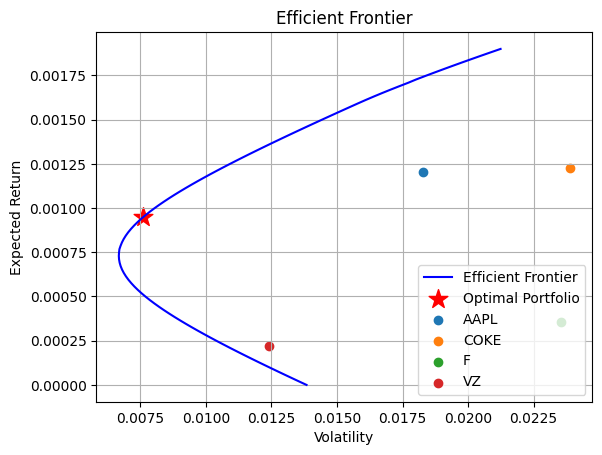

In [87]:
plt.plot(volatilities, returns, 'b-', label='Efficient Frontier')
plt.scatter(opt_port_volatility, opt_port_return, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Expected Return'].iloc[i], label=ticker)

plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

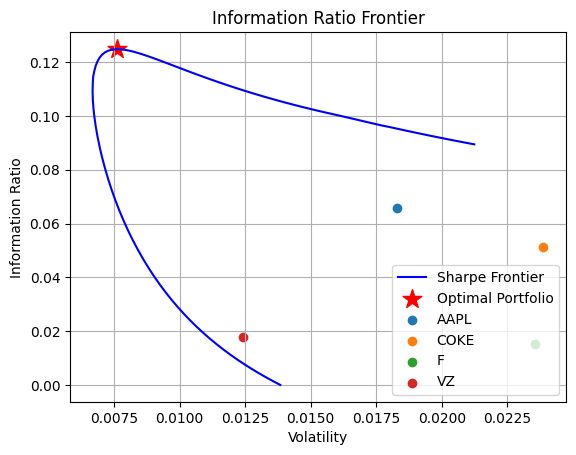

In [88]:
# Sharpe Graph
plt.plot(portfolios['Volatility'], portfolios['Sharpe Ratio'], 'b-', label='Sharpe Frontier')
plt.scatter(opt_port_volatility, opt_port_sharpe_ratio, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Sharpe Ratio'].iloc[i], label=ticker)

    
plt.xlabel('Volatility')
plt.ylabel('Information Ratio')
plt.title('Information Ratio Frontier')
plt.legend()
plt.grid(True)
plt.show()